In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [10]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
df = df[df.localization_node != 'localization_generator']
# df = df[df.amcl_alpha_factor == 1.0]

df = df[df.amcl_alpha_factor.isin([0.0, 0.5, 1.0, 2.0])].copy()

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    9403

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 1.0, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    fixed_rpp                                                              [False, True]

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['turtle']

    run_duplicate_index                                                    [nan, 1.0, 2.0]

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

## Metrics

    average_clearance                                                      min:      1.935             avg:      5.045             max:      12.42             nan:          0

    average_rotation_acceleration                                          min:  9.015e-06             avg:     0.1792             max:     0.9988             nan:        526

    average_rotation_velocity                                              min:  0.0006432             avg:     0.1373             max:     0.9651             nan:        526

    average_translation_acceleration                                       min:  6.565e-05             avg:     0.1207             max:     0.3207             nan:        526

    average_translation_velocity                                           min:  0.0008283             avg:     0.2536             max:       0.35             nan:        526

    average_velocity_atan                                                  min:    0.01885             avg:     0.3549             max:      1.328             nan:        526

    clearance                                                              min:        nan             avg:        nan             max:        nan             nan:       9403

    clearance_version                                                      [1.0]

    collision_rate                                                         min:          0             avg:    0.03244             max:          1             nan:          0

    collision_rate_version                                                 [3]

    collision_time                                                         min:       11.1             avg:      105.7             max:      432.1             nan:       9098

    absolute_rotation_error                                                min:  0.0003113             avg:    0.02081             max:     0.2085             nan:        541

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.03656             max:     0.7018             nan:        541

    absolute_translation_error                                             min:  0.0009009             avg:    0.09428             max:     0.5609             nan:        541

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:    0.04424             max:     0.4036             nan:        541

    collisionless_localization_update_error_version                        [1.0]

    normalized_relative_rotation_error                                     min:  0.0006716             avg:     0.2345             max:      13.03             nan:        541

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:      1.215             max:      46.61             nan:        541

    normalized_relative_translation_error                                  min:   0.001581             avg:    0.05641             max:     0.3278             nan:        541

    collisionless_localization_update_normalized_relative_translation_error_std min:          0             avg:    0.06164             max:     0.8927             nan:        541

    collisionless_localization_update_relative_rotation_error_mean         min:  0.0001568             avg:    0.01055             max:     0.3534             nan:        541

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:    0.03982             max:     0.9476             nan:        541

    collisionless_localization_update_relative_translation_error_mean      min:  0.0005164             avg:   0.009881             max:     0.2224             nan:        541

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:    0.01017             max:      1.124             nan:        541

    controller_cpu_time                                                    min:       0.57             avg:      60.88             max:      945.2             nan:          0

    controller_max_memory                                                  min:      21.52             avg:      42.75             max:      78.79             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      0.069             avg:      81.22             max:      577.4             nan:          0

    execution_time_version                                                 [1]

    localization_update_absolute_rotation_error_mean                       min:  0.0003113             avg:    0.02319             max:      1.495             nan:        541

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04055             max:      1.348             nan:        541

    localization_update_absolute_translation_error_mean                    min:  0.0009009             avg:    0.09609             max:      2.718             nan:        541

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.04646             max:      3.722             nan:        541

    localization_update_error_version                                      [1]

    localization_update_normalized_relative_rotation_error_mean            min:  0.0006716             avg:     0.2387             max:      13.03             nan:        541

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:      1.236             max:      46.61             nan:        541

    localization_update_normalized_relative_translation_error_mean         min:   0.001581             avg:    0.05985             max:      2.573             nan:        541

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.07036             max:      9.121             nan:        541

    localization_update_rate                                               min:     0.2364             avg:     0.8919             max:       32.4             nan:        540

    localization_update_rate_std                                           min:          0             avg:     0.3352             max:      14.34             nan:        540

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:  0.0001568             avg:    0.01142             max:     0.4347             nan:        541

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.04194             max:     0.9476             nan:        541

    localization_update_relative_translation_error_mean                    min:  0.0005164             avg:   0.009957             max:     0.2224             nan:        541

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01041             max:      1.124             nan:        541

    maximum_clearance                                                      min:      5.448             avg:      23.25             max:      29.82             nan:          0

    median_clearance                                                       min:     0.2977             avg:       3.96             max:      11.77             nan:          0

    minimum_clearance                                                      min:          0             avg:     0.6051             max:      5.803             nan:          0

    motion_characteristics_version                                         [4.0]

    odometry_error_alpha_1_mean                                            min:          0             avg:    0.06067             max:      6.012             nan:        540

    odometry_error_alpha_1_std                                             min:          0             avg:    0.07405             max:      28.09             nan:        540

    odometry_error_alpha_2_mean                                            min:          0             avg:    0.07529             max:      12.15             nan:        540

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1447             max:      33.95             nan:        540

    odometry_error_alpha_3_mean                                            min:  9.054e-18             avg:    0.06422             max:     0.9427             nan:        540

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01314             max:      1.442             nan:        540

    odometry_error_alpha_4_mean                                            min:  8.119e-18             avg:     0.2895             max:      1.372             nan:        540

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2416             max:      1.723             nan:        540

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.32             avg:      19.62             max:        395             nan:          0

    planner_max_memory                                                     min:      22.23             avg:      157.4             max:  3.116e+04             nan:          0

    success_rate                                                           min:          0             avg:     0.8857             max:          1             nan:          0

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:       2.35             avg:      89.08             max:       1121             nan:          0

    system_max_memory                                                      min:      132.2             avg:      320.6             max:  3.134e+04             nan:          0

    trajectory_length                                                      min:          0             avg:      19.48             max:      130.6             nan:          0

    trajectory_length_version                                              [1]

    translation_rotation_acceleration_product                              min:  6.189e-10             avg:    0.02916             max:     0.2301             nan:        526

    translation_rotation_product                                           min:  5.331e-07             avg:     0.0287             max:     0.1542             nan:        526

    average_velocity                                                       min:          0             avg:     0.2156             max:     0.2681             nan:          0

    norm_trajectory_length                                                 min:          0             avg:      0.988             max:      10.69             nan:          0

    mean_trajectory_length                                                 min:     0.9084             avg:      21.37             max:      100.8             nan:          0

    median_trajectory_length                                               min:      0.879             avg:      21.21             max:      100.5             nan:          0

    norm_trajectory_length_std                                             min:          0             avg:      4.846             max:      14.72             nan:          0

    norm_trajectory_length_mean                                            min:          0             avg:     0.9336             max:      8.022             nan:          0

    norm_trajectory_length_median                                          min:          0             avg:     0.9514             max:       9.52             nan:          0

    norm_execution_time                                                    min:  0.0003575             avg:      1.062             max:      12.74             nan:          0

In [6]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [25]:
max_scatter_points = 200
def plot_in_out_dist(x_metric, y_metric, x_bin_width, y_bin_width, selected_df, x_lim=None, y_lim=None, size=[4, 4], out_dir=None, scatter=False):
    
    for localization_node in selected_df.localization_node.unique():
        for local_planner_node in selected_df.local_planner_node.unique():

            df_notna = selected_df[
                (selected_df.localization_node == localization_node) & 
                (selected_df.local_planner_node == local_planner_node) & 
                selected_df[x_metric.name].notna() & 
                selected_df[y_metric.name].notna()
            ].copy()

            if len(df_notna[x_metric.name]) == 0:
                print(f"len(df_notna[{x_metric.name}]) == 0")
            else:
                if scatter:
                    n = max(1, int(len(df_notna[x_metric.name])/max_scatter_points))
                    plt.scatter(df_notna[x_metric.name][::n], df_notna[y_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])

                if x_bin_width:
                    bins_x = np.arange(0., x_metric.max() + x_bin_width, x_bin_width)
                    df_notna['x_range'] = pd.cut(df_notna[x_metric.name], bins_x, labels=bins_x[:-1]).astype('float')
                else:
                    bins_x = sorted(x_metric.unique())
                    df_notna['x_range'] = df_notna[x_metric.name]

                if y_bin_width:
                    bins_y = np.arange(0., y_metric.max() + y_bin_width, y_bin_width)
                    df_notna['y_range'] = pd.cut(df_notna[y_metric.name], bins_y, labels=bins_y[:-1]).astype('float')
                else:
                    bins_y = sorted(y_metric.unique())
                    df_notna['y_range'] = df_notna[y_metric.name]

                df_g = df_notna.groupby(['x_range', 'y_range']).count()[y_metric.name]
                
                s = df_g.sum()
                m = np.zeros((len(bins_x), len(bins_y)))
                for i_x, x in enumerate(bins_x):
                    for i_y, y in enumerate(bins_y):
                        m[i_x, i_y] = df_g[(x, y)]/s if (x, y) in df_g.index else 0
                
                if f"{np.sum(m):g}" != f"{1.0:g}":
                    print_warn(f"np.sum(m) == {np.sum(m)} != 1.0")
                
                fig = plt.figure()
                y_quota = np.max(bins_y)/y_lim[1] if y_lim else 1
                x_quota = np.max(bins_x)/x_lim[1] if x_lim else 1
                plt.imshow(m.T, origin='lower', aspect=len(bins_x)/len(bins_y)*y_quota/x_quota)
                plt.title(f"{local_planner_node}, {localization_node}".replace('_', ' '))
                
                x_ticks_pos = np.arange(len(bins_x)) - 0.5*(x_bin_width is not None)
                if isinstance(bins_x[0], str):
                    plt.xticks(x_ticks_pos, bins_x, rotation=-90)
                else:
                    plt.xticks(x_ticks_pos, map(lambda x: f"{x:g}", bins_x), rotation=-90)
                y_ticks_pos = np.arange(len(bins_y)) - 0.5*(y_bin_width is not None)
                if isinstance(bins_y[0], str):
                    plt.yticks(y_ticks_pos, bins_y)
                else:
                    plt.yticks(y_ticks_pos, map(lambda y: f"{y:g}", bins_y))
                plt.xlabel(x_metric.name.replace('_', ' '))
                plt.ylabel(y_metric.name.replace('_', ' '))
                
                if y_lim:
                    plt.ylim(np.array(y_lim)/y_bin_width)
                if x_lim:
                    plt.xlim(np.array(x_lim)/x_bin_width)
                fig.set_size_inches(size)
                if out_dir:
                    if not path.exists(out_dir):
                        os.makedirs(out_dir)
                    fig.savefig(out_dir + f"/{y_metric.name}---{x_metric.name}--{local_planner_node}--{localization_node}--joint-distribution.pdf".replace('_', '-'), bbox_inches='tight')
                plt.show()
                plt.close()


# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'dwb')].copy()
# x_metrics_and_bin_widths = [
#     [d.average_velocity_atan, 0.1],
#     [d.beta_1, None],
#     [d.environment_name, None],
# ]
# y_metrics_and_bin_widths = [
#     [d.absolute_translation_error, 0.02],
# ]
# for x_metric, x_bin_width in x_metrics_and_bin_widths:
#     printmd(f"### {x_metric.name.replace('_', ' ')}")
#     for y_metric, y_bin_width in y_metrics_and_bin_widths:
#         printmd(f"### {y_metric.name.replace('_', ' ')}")
#         plot_in_out_dist(
#             x_metric=x_metric, 
#             y_metric=y_metric, 
#             x_bin_width=x_bin_width,
#             y_bin_width=y_bin_width,
#             selected_df=d,
#             y_lim=(0, 0.6),
#             out_dir="thesis_plots/localization",
#         )


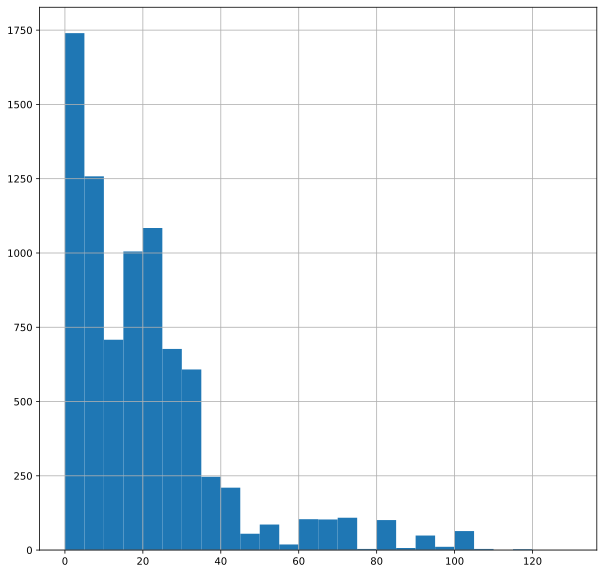

In [20]:
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
bins = np.arange(d.trajectory_length.min(), d.trajectory_length.max(), 5)
d['trajectory_length_d'] = pd.cut(d.trajectory_length, bins, labels=bins[:-1]).astype('float')
d.trajectory_length_d.hist(bins=bins)

## Localization performance from system features

### average velocity

#### normalized relative translation error

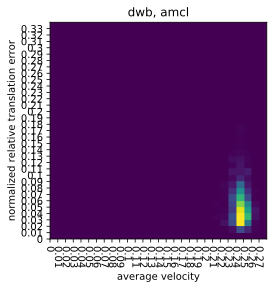

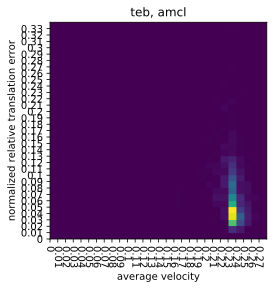

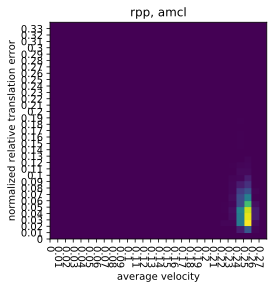

#### normalized relative rotation error

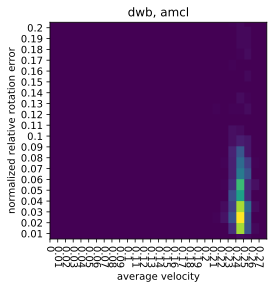

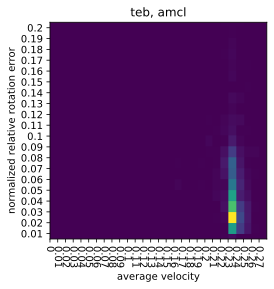

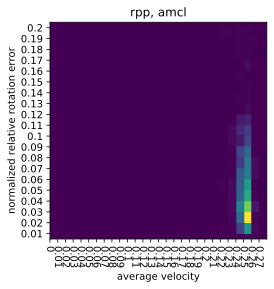

### average translation velocity

#### normalized relative translation error

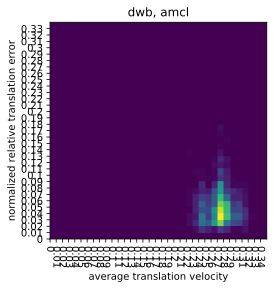

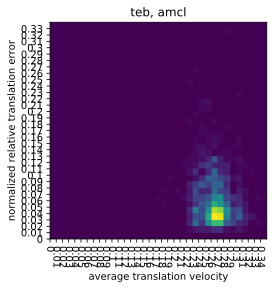

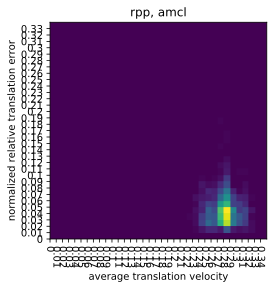

#### normalized relative rotation error

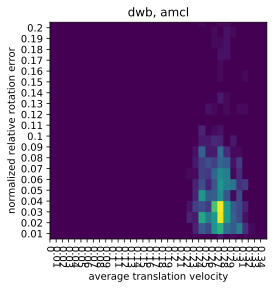

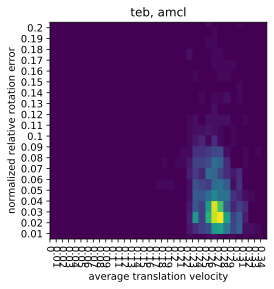

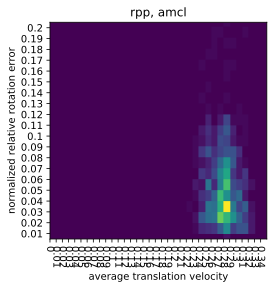

### average velocity atan

#### normalized relative translation error

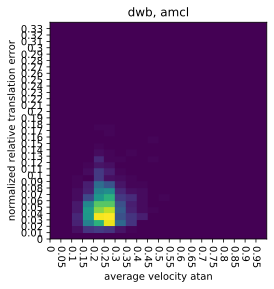

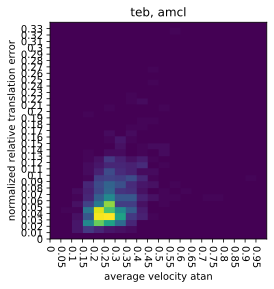

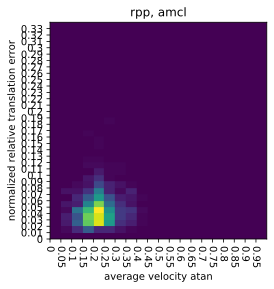

#### normalized relative rotation error

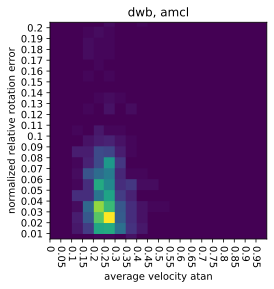

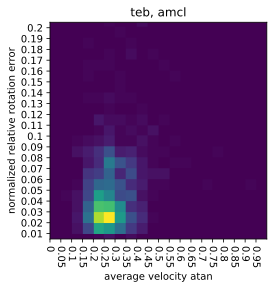

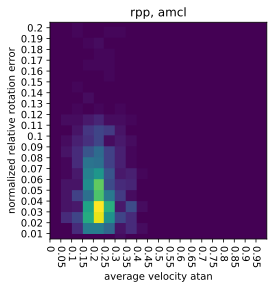

In [12]:
printmd("## Localization performance from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.trajectory_length > 20)].copy()
for x_metric, x_bin_width, x_lim in [
    [d.average_velocity, 0.01, None], 
    [d.average_translation_velocity, 0.01, None], 
    [d.average_velocity_atan, 0.05, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
#         [d.absolute_translation_error, 0.01, None],
#         [d.absolute_rotation_error, 0.01, None],
        [d.normalized_relative_translation_error, 0.01, None],
        [d.normalized_relative_rotation_error, 0.01, (0, 0.2)],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/localization_l20",
        )


### norm trajectory length from localization error

when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length

### absolute translation error

#### norm trajectory length

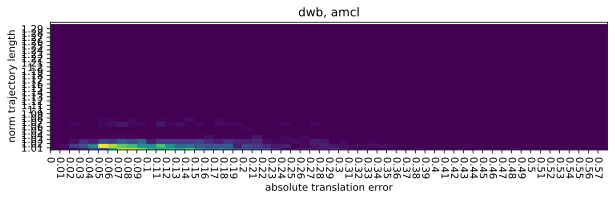

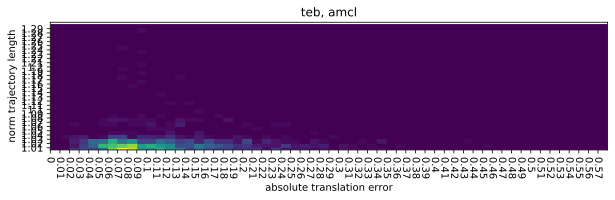

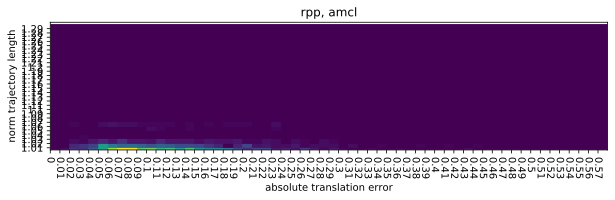

### absolute rotation error

#### norm trajectory length

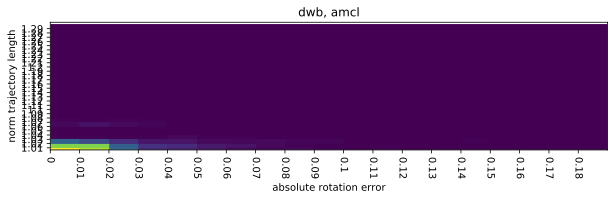

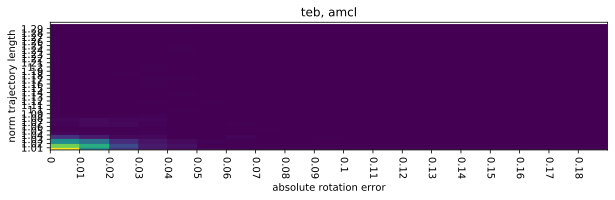

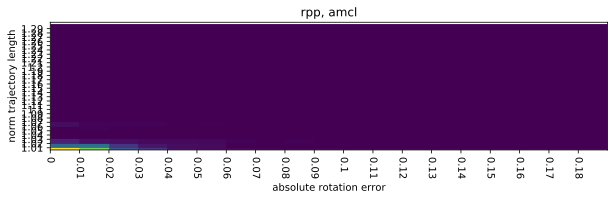

### normalized relative translation error

#### norm trajectory length

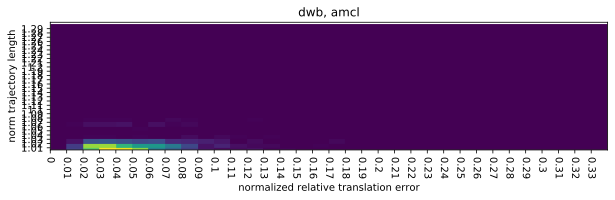

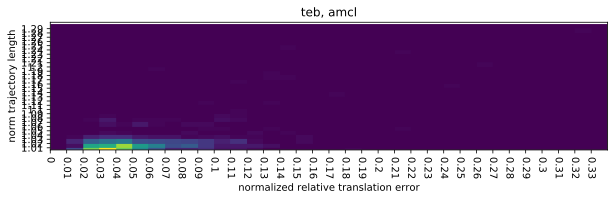

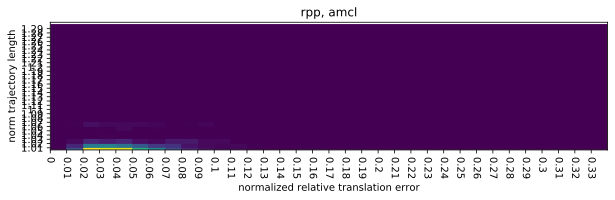

### normalized relative rotation error

#### norm trajectory length

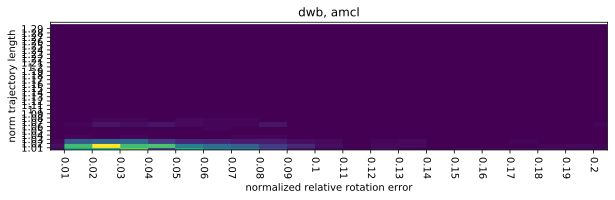

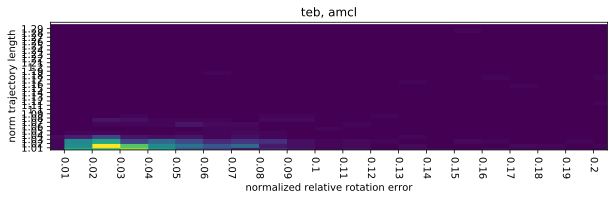

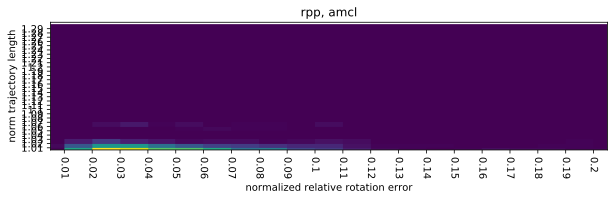

In [26]:

printmd("### norm trajectory length from localization error")
printmd("when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.trajectory_length > 20)].copy()
for x_metric, x_bin_width, x_lim in [
    [d.absolute_translation_error, 0.01, None],
    [d.absolute_rotation_error, 0.01, None],
    [d.normalized_relative_translation_error, 0.01, None],
    [d.normalized_relative_rotation_error, 0.01, (0, 0.2)],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.norm_trajectory_length, 0.01, (1.0, 1.3)],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            size=[10, 10],
            out_dir="thesis_plots/local_planner",
        )


## Local Planning performance from robot params, localization params, and environment features

### beta 1

#### average velocity atan

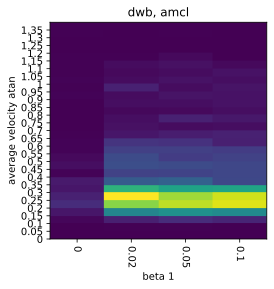

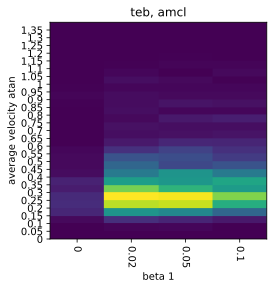

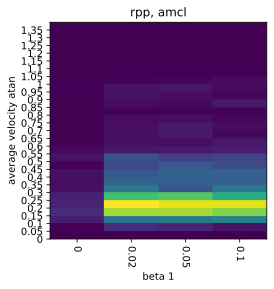

### amcl alpha factor

#### average velocity atan

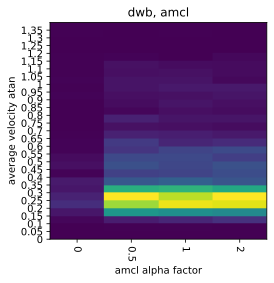

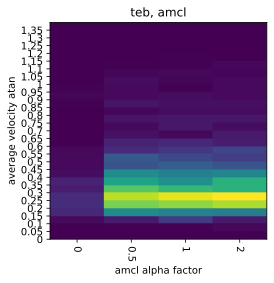

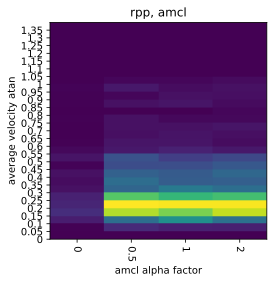

### minimum clearance

#### average velocity atan

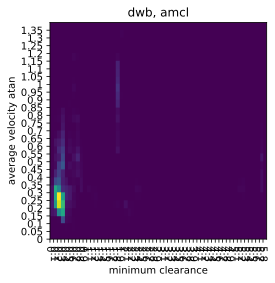

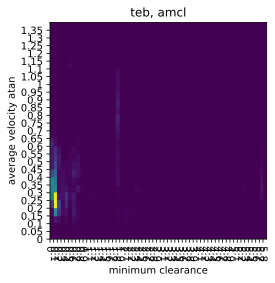

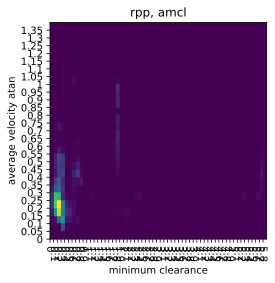

### average clearance

#### average velocity atan

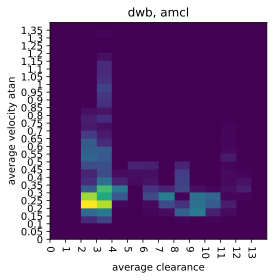

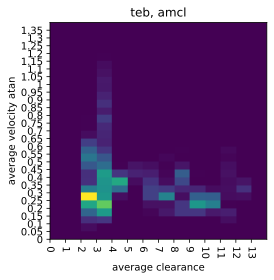

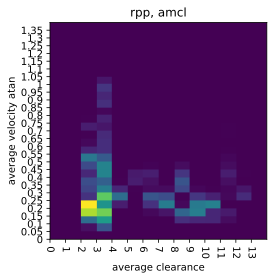

In [23]:

printmd("## Local Planning performance from robot params, localization params, and environment features")

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
    [d.beta_1, None, None],
    [d.amcl_alpha_factor, None, None],
    [d.minimum_clearance, .1, None],
    [d.average_clearance, 1, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.average_velocity_atan, 0.05, None],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/local_planner",
        )


In [ ]:
## plots_local_planner

printmd("## Local Planning performance from from robot params, localization params, and environment features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
    [d.beta_1, None, None],
    [d.amcl_alpha_factor, None, None],
    [d.minimum_clearance, .1, None],
    [d.average_clearance, 1, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.success_rate, None, None],
        [d.collision_rate, None, None],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/local_planner",
        )


d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
for x_metric, x_bin_width, x_lim in [
    [d.beta_1, None, None],
    [d.amcl_alpha_factor, None, None],
    [d.minimum_clearance, .1, None],
    [d.average_clearance, 1, None],
]:
    printmd(f"### {x_metric.name.replace('_', ' ')}")
    for y_metric, y_bin_width, y_lim in [
        [d.norm_trajectory_length, 0.01, (1.0, 1.5)],
    ]:
        printmd(f"#### {y_metric.name.replace('_', ' ')}")
        plot_in_out_dist(
            x_metric=x_metric,
            y_metric=y_metric,
            x_bin_width=x_bin_width,
            y_bin_width=y_bin_width,
            selected_df=d,
            x_lim=x_lim,
            y_lim=y_lim,
            out_dir="thesis_plots/local_planner",
        )
